  # Analyzing, Filtering, and Cleaning Aviation Database for the Safest Plane
                                          Jupyter Notebook coded by Allison Ward, Rick Lataille, and Anthony Mansion

### As usual, imported pandas to manage big data, as well as numpy for future statistical analysis

In [55]:
#Import the modules we need
import pandas as pd
import numpy as np

# And this is the big data that we will be using
df = pd.read_csv('Aviation_Data.csv', low_memory=False)

### Here, we will be dropping columns we see no need for, the information isn't relevant. These columns are dropped because the information it provides has no use in finding the results our stakeholder is looking for.

In [56]:
# Drop the columns we know that we don't need
dropped_columns = ['Schedule', 'Report.Status', 'Publication.Date']
df.drop(columns = dropped_columns, inplace=True)
print(f"{len(df)} items.")

90348 items.


### Now looking at the rest of the columns, we filter some columns for the information we need. We leave the original "df" alone and instead make another variable to hold our filtered information. The ways we filtered were: filtering for rows with data from the last 10 years + turned into date-time, and also created days of the week using those, filter data for aircrafts to airplanes only since that's the data we will be using, exclude the rows for planes that are amateur built since they... kind of screw the results we need over, filtered even more plane uses to continue providing relevant data adjusted to our stakeholder, and lastly filtering for the United States only. Filtering for the U.S. only is mainly because the rows that aren't in here aren't filled and can't tell of anything, and it even the same case for the U.S. territories that aren't between the Altantic and Pacific Oceans. Dropped from about 90,000 items to 7,000.

In [57]:
# Convert date column to datetime, then filter event dates to include 2013 and later
df['Event.Date'] = pd.to_datetime(df['Event.Date'])
df_filtered = df.loc[df['Event.Date'] >= '2013-01-01']
print(f"{len(df_filtered)} items.")

# Creating a new column with Day of Week
df_filtered['Day_Of_Week'] = df['Event.Date'].dt.day_name()

# Filter aircraft categories for Airplanes only
df_filtered = df_filtered.loc[df_filtered['Aircraft.Category'] == 'Airplane']
print(f"{len(df_filtered)} items.")

# Exclude Amateur-built planes
df_filtered = df_filtered.loc[df_filtered['Amateur.Built'] != 'Yes']
print(f"{len(df_filtered)} items.")

# Exclude certain identified purposes as irrelevant to our stakeholder
allowed_purposes = ['Personal', np.nan, 'Business', 'Executive/corporate', \
                    'Positioning', 'Other Work Use', 'Ferry', 'Unknown', 'Public Aircraft - Federal', \
                   'Public Aircraft - State', 'Public Aircraft - Local', 'Public Aircraft', 'PUBS']
df_filtered = df_filtered.loc[df_filtered['Purpose.of.flight'].isin(allowed_purposes)]
print(f"{len(df_filtered)} items.")

# Include only events that happened in the United States or US Territories
allowed_countries = ['United States']
df_filtered = df_filtered.loc[df_filtered['Country'].isin(allowed_countries)]
print(f"{len(df_filtered)} items.")

# Drop even more columns that are no longer useful
obsolete_columns = ['Event.Id', 'Country', 'Aircraft.Category', 'Registration.Number', 'Broad.phase.of.flight']
df_filtered.drop(columns = obsolete_columns, inplace=True)

15829 items.
13262 items.
11726 items.
9497 items.
7320 items.


C:\Users\mansi\AppData\Local\Temp\ipykernel_11640\4153400819.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Day_Of_Week'] = df['Event.Date'].dt.day_name()


## Alriight, now that we've done as much filtering we believe we need, we move on to cleaning the remaining columns.  And if you threw the CSV into Tableau, you'd notice that-- even though we filtered for the United States specifically-- some of the points in the map are NOT in the United States, or even U.S. territories. So the cell block below was to try and limit the lies the data was telling us, or just lazy humans being human or something. 

In [58]:
# Filter for foreign locations not noted as foreign using the 'OF' state code in Location
df_filtered['State_Code'] = df_filtered['Location'].str.slice(-2)
df_filtered = df_filtered.loc[df_filtered['State_Code'] != 'OF']
print(f"{len(df_filtered)} items.")

# Drop rows that are missing latitude coordinates (also captures missing Longitude)
df_filtered.dropna(subset=['Latitude'], inplace=True)
print(f"{len(df_filtered)} items.")

#Converting latitude and longitude from Degrees, Minutes, and Seconds to Decimal Degrees

df_filtered.dropna(subset=['Latitude', 'Longitude'], inplace=True)

def convert_latitude(x):
    degrees = float(x[:2])
    minutes = float(x[2:4])
    seconds = float(x[4:6])
    return degrees + minutes/60 + seconds/3600

df_filtered["new_lats"] = df_filtered['Latitude'].map(convert_latitude)

def convert_longitude(x):
    degrees = float(x[:3])
    minutes = float(x[3:5])
    seconds = float(x[5:7])
    return -(degrees + minutes/60 + seconds/3600)

df_filtered["new_longs"] = df_filtered['Longitude'].map(convert_longitude)

7307 items.
7302 items.


### As you may know, Python is case sensitive, and the data does NOT reflect that. And because of that, things that should be grouped together will be grouped seperatively based on one just starting with "A" instead of "a." So it's time to fix that. :) The original_makes variable wasn't useful in the long run, it was just as a way to see how many duplicates were left and things like that. Lamba function was used to try and clean the names. I know its a LOT of pretty much the same lines, but knowing the natural language processing or any other methods is currently beyond our levels, so unfortunately we have to do what we had to do. Lol

In [59]:
# Record original makes for later comparison
Original_makes = len(df_filtered['Make'].unique())

In [60]:
# These map functions will clean the 'Make' column, A-C
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Aerofab" if x.lower().strip()[:7]=="aerofab" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Aeroprakt" if x.lower().strip()[:9]=="aeroprakt" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Aeropro" if x.lower().strip()[:7]=="aeropro" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Aerostar" if x.lower().strip()[:8]=="aerostar" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Aerostar" if x.lower().strip()[:3]=="s c" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Aerotek" if x.lower().strip()[:7]=="aerotek" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Air Tractor" if x.lower().strip()[:11]=="air tractor" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Airbus" if x.lower().strip()[:6]=="airbus" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Airbus" if x.lower().strip()[:5]=="fouga" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Aircraft Mfg" if x.lower().strip()[:12]=="aircraft mfg" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "American Champion" if x.lower().strip()[:17]=="american champion" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "American Legend" if x.lower().strip()[:15]=="american legend" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Arion" if x.lower().strip()[:5]=="arion" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Aviat" if x.lower().strip()[:5]=="aviat" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Avions" if x.lower().strip()[:6]=="avions" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "BAE" if x.lower().strip()[:3]=="bae" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Boeing" if x.lower().strip()[:6]=="boeing" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Boeing" if x.lower().strip()[:9]=="mcdonnell" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Boeing" if x.lower().strip()[:7]=="douglas" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Boeing" if x.lower().strip()[:8]=="rockwell" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Bombardier" if x.lower().strip()[:10]=="bombardier" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Bombardier" if x.lower().strip()[:5]=="gates" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Bombardier" if x.lower().strip()[:7]=="learjet" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Bombardier" if x.lower().strip()[:8]=="canadair" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "BAE" if x.lower().strip()[:12]=="british aero" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Britten-Norman" if x.lower().strip()[:7]=="britten" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Bucker" if x.lower().strip()[:6]=="bucker" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Cirrus" if x.lower().strip()[:6]=="cirrus" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Convair" if x.lower().strip()[:12]=="consolidated" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "CubCrafters" if x.lower().strip()[:3]=="cub" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Czech" if x.lower().strip()[:5]=="czech" else x)

In [61]:
# These map functions will clean the 'Make' column, D-N
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Daher" if x.lower().strip()[:3]=="s.o" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Daher" if x.lower().strip()[:3]=="soc" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Dassault" if x.lower().strip()[:8]=="dassault" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "De Havilland" if x.lower().strip()[:6]=="de hav" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "De Havilland" if x.lower().strip()[:5]=="dehav" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Diamond" if x.lower().strip()[:7]=="diamond" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Eclipse" if x.lower().strip()[:7]=="eclipse" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Embraer" if x.lower().strip()[:7]=="embraer" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Evektor" if x.lower().strip()[:7]=="evektor" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Evolution" if x.lower().strip()[:9]=="evolution" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Extra" if x.lower().strip()[:5]=="extra" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Fairchild" if x.lower().strip()[:9]=="fairchild" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Fantasy Air" if x.lower().strip()[:7]=="fantasy" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Flight Design" if x.lower().strip()[:8]=="flight d" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Flightstar" if x.lower().strip()[:7]=="flights" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "FPNA" if x.lower().strip()[:4]=="fpna" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Glasair" if x.lower().strip()[:7]=="glasair" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Golden Circle" if x.lower().strip()[:8]=="golden c" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Gulfstream" if x.lower().strip()[:10]=="gulfstream" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Gulfstream" if x.lower().strip()[:3]=="iai" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Honda" if x.lower().strip()[:5]=="honda" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Jabiru" if x.lower().strip()[:6]=="jabiru" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Lancair" if x.lower().strip()[:7]=="lancair" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Maxair" if x.lower().strip()[:6]=="maxair" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Meyers" if x.lower().strip()[:6]=="meyers" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Mooney" if x.lower().strip()[:6]=="mooney" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "M-Squared" if x.lower().strip()[:9]=="m-squared" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Nanchang" if x.lower().strip()[:8]=="nanchang" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Northrop Grumman" if x.lower().strip()[:7]=="grumman" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Northrop Grumman" if x.lower().strip()[:8]=="northrop" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "North American" if x.lower().strip()[:8]=="north am" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "North Wing" if x.lower().strip()[:7]=="north w" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "North Wing" if x.lower().strip()[:6]=="northw" else x)

In [62]:
# These map functions will clean the 'Make' column, N-Z
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Orlican" if x.lower().strip()[:7]=="orlican" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Phantom" if x.lower().strip()[:7]=="phantom" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Pilatus" if x.lower().strip()[:7]=="pilatus" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Piper" if x.lower().strip()[:9]=="new piper" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Piper" if x.lower().strip()[:5]=="piper" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Pipistrel" if x.lower().strip()[:4]=="pipi" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Pitts" if x.lower().strip()[:5]=="pitts" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Pzl Okecie" if x.lower().strip()[:3]=="pzl" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Quad City" if x.lower().strip()[:4]=="quad" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Quest" if x.lower().strip()[:5]=="quest" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Quicksilver" if x.lower().strip()[:5]=="quick" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Rans" if x.lower().strip()[:4]=="rans" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Remos" if x.lower().strip()[:5]=="remos" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Rockwell" if x.lower().strip()[:8]=="rockwell" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Ryan" if x.lower().strip()[:4]=="ryan" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Scoda" if x.lower().strip()[:5]=="scoda" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Short" if x.lower().strip()[:5]=="short" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Stearman" if x.lower().strip()[:8]=="stearman" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Taylorcraft" if x.lower().strip()[:7]=="taylorc" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Textron" if x.lower().strip()[:6]=="cessna" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Textron" if x.lower().strip()[:4]=="rath" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Textron" if x.lower().strip()[:4]=="rayt" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Textron" if x.lower().strip()[:7]=="textron" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Textron" if x.lower().strip()[:5]=="beech" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Textron" if x.lower().strip()[:6]=="hawker" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "TL Ultralight" if x.lower().strip()[:2]=="tl" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Vans" if x.lower().strip()[:4]=="vans" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Waco" if x.lower().strip()[:4]=="waco" else x)
df_filtered['Make'] = df_filtered['Make'].map(lambda x: "Zlin" if x.lower().strip()[:4]=="zlin" else x)

In [63]:
# Show the amount of consolidation in makes
print(f"The original {Original_makes} makes have been reduced to {len(df_filtered['Make'].unique())} makes.")

The original 670 makes have been reduced to 433 makes.


### Getting rid of whack "NaN", "None", or "Uknown" by appropriately filling in values for data usage

In [64]:
# Change "NaN" to 'None' or 'Unknown', as appropriate
df_filtered['Injury.Severity'].fillna('None', inplace=True)
df_filtered['Aircraft.damage'].fillna('Unknown', inplace=True)
df_filtered['Purpose.of.flight'].fillna('Unknown', inplace=True)
df_filtered['Engine.Type'].fillna('Unknown', inplace=True)
df_filtered['FAR.Description'].fillna('Unknown', inplace=True)
df_filtered['Number.of.Engines'].fillna('Unknown', inplace=True)

# This will convert all 'unknown' type entries to 'Unknown' in the Air.carrier field
df_filtered['Air.carrier'].fillna('Unknown', inplace=True)
df_filtered['Air.carrier'] = df_filtered['Air.carrier'].astype(str).map(
    lambda x: "Unknown" if x.lower().strip()[:3]=="unk" else x)

# This will convert all 'unknown' type entries to 'Unknown' in the Weather.Condition field
df_filtered['Weather.Condition'].fillna('Unknown', inplace=True)
df_filtered['Weather.Condition'] = df_filtered['Weather.Condition'].astype(str).map(
    lambda x: "Unknown" if x.lower().strip()[:3]=="unk" else x)

### All of these lines have completely different functions, and some is more filtering than cleaning, or neither, but had to make a little more moves to get even MORE of the data comparisons we wanted to include.

In [65]:
# Put all Makes into Title case, for readability
df_filtered['Make'] = df_filtered['Make'].map(lambda x: x.title())

# Use dt functions to extract year and month and create new columns
df_filtered['Year'] = df['Event.Date'].dt.year
df_filtered['Month'] = df['Event.Date'].dt.month

# Create a new column to simplify the large jet analysis
separate_large_jets = ["Airbus", "Boeing", "Embraer"]
df_filtered['Large_Jets'] = df_filtered['Make'].map(lambda x: "Other" if x not in separate_large_jets else x)

# Create a new column to simplify the large jet analysis
separate_small_jets = ["Bombardier", "Dassault", "Gulfstream", "Honda", "Textron"]
df_filtered['Small_Jets'] = df_filtered['Make'].map(lambda x: "Other" if x not in separate_small_jets else x)

# Create a new column summing fatal and serious injuries
df_filtered['Major_Injuries'] = df_filtered['Total.Fatal.Injuries'] + df_filtered['Total.Serious.Injuries']

### With all that filtered data, saved it to a new csv file for an even easier time making visualizations of the data since all the info we need won't be surrounded by the other  random information. We also did this instead of overwriting the original "just in case", y'know? Just in case we wanted to undo something, we could simply overwrite the csv and throw it back into Tableau real fast.

In [66]:
# Write to a new CSV file/overwrites CSV file
df_filtered.to_csv('Filtered_Aviation_Data.csv', index=False)

## ACTUALLY just random garbage below 😡 (No really, literally everything this markdown was honestly just a waste of time and energy. Smh  They were most likely another idea we had where when coded partway, we realized that Tableau literally exists or maybe just scrapped it because of reason x, with maybe an extra y or z to it)

### The Tests of Hell. (Honestly, this whole part is irrelevant and would have been 1,000 times easier and waaaay more efficient rather than "hard-coding" it. 😔 But the lines have already written, so we just had to see it through...) The test here is grabbing many random categories, and using those to make comparisons between other random categories. I was going to then import matplotlib to begin making visualizations, but I already realized how unefficient I was working and the time I was wasting when I could have just thrown the csv in Tableau... 

In [67]:
# In this cell block below, I will do even further filtering to whittle down numbers and find the best plane
# The filters will be based on how safe they are, so how less they repeat by finding: the number of engines that
# appear the least, the type of engine that appears the least, non-fatal injuries, substantial damage to plane

# First, made a copy of the current filtered datamframe to filter even more
# Filtering by injuries to see comparisons between resullts
Fatal_Inj = df.loc[df['Total.Fatal.Injuries'] > 0]
Serious_Inj = df.loc[df['Total.Serious.Injuries'] > 0]
Minor_Inj = df.loc[df['Total.Minor.Injuries'] > 0]
Uninjured = df.loc[(df['Total.Uninjured'] > 0) & (df['Total.Minor.Injuries'] == 0)] 

# Hmm... lets see the difference between substantial damage, too
Sub_Damage = df.loc[df['Aircraft.damage'] == 'Substantial'] # (Substantial Damage)
Destroyed = df.loc[df['Aircraft.damage'] == 'Destroyed'] # (Destroyed planes)
Minor_Damage = df.loc[df['Aircraft.damage'] == 'Minor']            

# Looking at the difference between data using engine types as well
Reciprocating_Eng = df.loc[df['Engine.Type'] == 'Reciprocating'] 
Turbo_Shaft = df.loc[df['Engine.Type'] == 'Turbo Shaft']
Turbo_Prop = df.loc[df['Engine.Type'] == 'Turbo Prop']
Turbo_Fan = df.loc[df['Engine.Type'] == 'Turbo Fan']
Turbo_Jet = df.loc[df['Engine.Type'] == 'Turbo Jet']
Geared_Turbofan = df.loc[df['Engine.Type'] == 'Geared Turbofan']
Electric = df.loc[df['Engine.Type'] == 'Electric']
LR = df.loc[df['Engine.Type'] == 'LR'] 
NONE = df.loc[df['Engine.Type'] == 'NONE'] 
Hyrbrid_Rocket = df.loc[df['Engine.Type'] == 'Hyrbrid Rocket'] 
UNK = df.loc[df['Engine.Type'] == 'UNK']

# Seeing if there are different results using the number of engines, too
NO_ENGINES = df.loc[df['Number.of.Engines'] == 0] #??!!
One_Engine = df.loc[df['Number.of.Engines'] == 1] 
Two_Engines = df.loc[df['Number.of.Engines'] == 2] 
Three_Engines = df.loc[df['Number.of.Engines'] == 3] 
Four_Engines = df.loc[df['Number.of.Engines'] == 4] 

### Now at this point is when we WOULD HAVE imported matplotlib, but we already realized a few lines into the cell block above that we were just wasting time and that it'd be better to just use Tableau. But below, I made a third corny variable (which is why the name is very bad lol) to become the dataframe that will be used for comparisons. But in order to compare each, I have to reset the new variable by making it the old dataframe each time or it will just get smaller and smaller. (Just realized we didn't even use those variables above, haha...😭)

In [68]:
# Make a new dataframe variable so we could the filtered dataset of the original aviation dataset,
# we can compare the data we seperated. Still with us after that?
df_filterered = df_filtered

# Filtering the filtered dataset of the original aviation dataset, we can compare the data we seperated
df_filterered = df_filterered.loc[df['Aircraft.damage'] == 'Substantial']
df_filterered = df_filterered.loc[df['Total.Uninjured'] > 0]
df_filterered = df_filterered.loc[df['Number.of.Engines'] == 2] 

# Woow, its the new dataframe! Again, would have used matplotlib here, but naaaah. Let's not please. 
df_filterered

,Investigation.Type,Accident.Number,Event.Date,Location,Latitude,Longitude,Airport.Code,Airport.Name,Injury.Severity,Aircraft.damage,...,Weather.Condition,Day_Of_Week,State_Code,new_lats,new_longs,Year,Month,Large_Jets,Small_Jets,Major_Injuries
73204,Accident,CEN13CA129,2013-01-11,"Alexandria, MN",455145N,0095240W,AXN,Alexindria Municipal Airport,Non-Fatal,Substantial,...,IMC,Friday,MN,45.862500,-9.877778,2013.0,1.0,Other,Textron,0.0
73286,Accident,ERA13LA129,2013-02-07,"Winston-Salem, NC",003681N,0801319W,INT,Smith Reynolds Airport,Non-Fatal,Substantial,...,VMC,Thursday,NC,0.622500,-80.221944,2013.0,2.0,Other,Textron,0.0
73313,Accident,CEN13CA162,2013-02-14,"Abilene, TX",323031N,0993626W,NaN,NaN,Non-Fatal,Substantial,...,VMC,Thursday,TX,32.508611,-99.607222,2013.0,2.0,Other,Textron,0.0
73321,Accident,ANC13CA023,2013-02-16,"Dutch Harbor, AK",535334N,1663225W,PADU,Unalaska,Non-Fatal,Substantial,...,VMC,Saturday,AK,53.892778,-166.540278,2013.0,2.0,Other,Other,0.0
73329,Accident,WPR13LA132,2013-02-17,"Casper, WY",425417N,1062731W,CPR,Casper/Natrona County Int'l,Non-Fatal,Substantial,...,VMC,Sunday,WY,42.904722,-106.458611,2013.0,2.0,Other,Textron,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90275,Accident,CEN23LA052,2022-11-22,"Denton, TX",292548N,1005924W,NaN,NaN,Non-Fatal,Substantial,...,Unknown,Tuesday,TX,29.430000,-100.990000,2022.0,11.0,Other,Textron,0.0
90293,Accident,CEN23LA056,2022-11-29,"Batesville, AR",354334N,0913851W,BVX,Batesville Regional Airport,Minor,Substantial,...,IMC,Tuesday,AR,35.726111,-91.647500,2022.0,11.0,Other,Bombardier,2.0
90295,Accident,ERA23LA075,2022-11-30,"Newport News, VA",037816N,0762838W,PHF,NEWPORT NEWS/WILLIAMSBURG INTL,Non-Fatal,Substantial,...,VMC,Wednesday,VA,4.304444,-76.477222,2022.0,11.0,Other,Bombardier,0.0
90328,Accident,WPR23LA065,2022-12-13,"Lewistown, MT",047257N,0109280W,KLWT,Lewiston Municipal Airport,Non-Fatal,Substantial,...,Unknown,Tuesday,MT,5.215833,-11.555556,2022.0,12.0,Other,Other,0.0


### Blah blah blah Tableau exist, same yap as the 3 above markdowns, but split into a thousand cell blocks

In [69]:
# Separating the city and state from the Location column and creating a new column for the state
# (from https://www.kaggle.com/code/tetianalys605/aviation-accidents-python-analysis)
df_filtered['State'] = df_filtered['Location'].str.split(',').str[1]

In [70]:
#Getting the top 15 states with the most incidents in our data set
df_filtered['State'].value_counts(ascending = False).head(15)

State
 AK    706
 CA    678
 TX    589
 FL    500
 AZ    235
 CO    230
 GA    223
 WA    202
 ID    187
 NC    184
 NY    170
 PA    169
 OR    158
 OH    154
 MI    153
Name: count, dtype: int64

In [71]:
# Taking a look at weather conditions
df_filtered['Weather.Condition'].value_counts()

Weather.Condition
VMC        6454
IMC         448
Unknown     400
Name: count, dtype: int64

In [72]:
# Determining the states with the highest number of incidents under VMC conditions
state_VMC = df_filtered['State'].loc[df_filtered['Weather.Condition'] == 'VMC']
top_15_state_VMC = state_VMC.value_counts().head(15)
top_15_state_VMC

State
 AK    636
 CA    602
 TX    517
 FL    453
 AZ    216
 CO    201
 GA    191
 WA    179
 ID    176
 NC    159
 PA    152
 NY    146
 OR    141
 OH    139
 MI    134
Name: count, dtype: int64

In [73]:
# Determining the states with the highest number of incidents under IMC conditions
state_IMC = df_filtered['State'].loc[df_filtered['Weather.Condition'] == 'IMC']
top_15_state_IMC = state_IMC.value_counts().head(15)
top_15_state_IMC

State
 TX    39
 AK    33
 FL    26
 CA    23
 GA    23
 NC    18
 TN    16
 NY    15
 IL    14
 CO    14
 MN    13
 VA    12
 WI    12
 MI    12
 MO    11
Name: count, dtype: int64

In [74]:
# Looking at fatality counts per state
state_fatality = df_filtered['State'].loc[df_filtered['Injury.Severity'] == 'Fatal']
state_fatality_top_15 = state_fatality.value_counts().head(15)
state_fatality_top_15

State
 CA    149
 TX    101
 FL     91
 AK     73
 GA     55
 CO     37
 NC     34
 AZ     33
 NY     30
 OH     28
 MI     28
 TN     26
 NM     25
 OR     25
 IL     25
Name: count, dtype: int64

In [75]:
# Looking at non-fatality counts per state
state_non_fatality = df_filtered['State'].loc[df_filtered['Injury.Severity'] != 'Fatal']
state_non_fatality_top_15 = state_non_fatality.value_counts().head(15)
state_non_fatality_top_15

State
 AK    633
 CA    529
 TX    488
 FL    409
 AZ    202
 CO    193
 WA    178
 GA    168
 ID    164
 PA    152
 NC    150
 NY    140
 OR    133
 OH    126
 MI    125
Name: count, dtype: int64

In [76]:
# Switching Event Date column to pandas date time
df_filtered['Event.Date'] = pd.to_datetime(df_filtered['Event.Date'])

In [77]:
# Creating a new column with Day of Week
df_filtered['Day_Of_Week'] = df['Event.Date'].dt.day_name()

In [78]:
# Finding value counts in the Day_of_Week column
day_of_week = df_filtered['Day_Of_Week'].value_counts()
day_of_week

Day_Of_Week
Saturday     1388
Sunday       1237
Friday       1074
Thursday      961
Monday        942
Wednesday     910
Tuesday       790
Name: count, dtype: int64

## Guess 🗿 (Tableau copium part 5 btw)

In [79]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

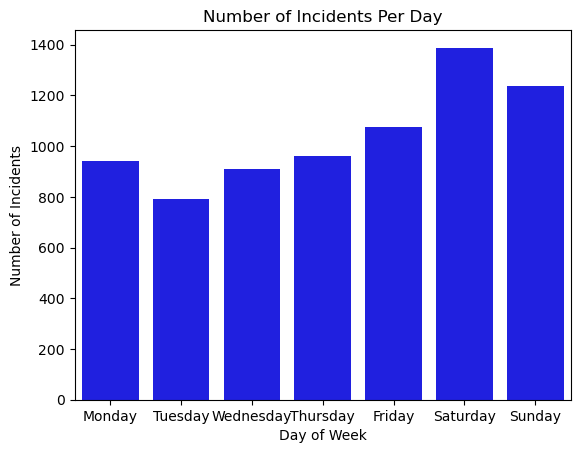

In [80]:
# Plotting Number of Incidents per Day of the Week
plot = sns.countplot(x = 'Day_Of_Week', order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'], color = 'b', data = df_filtered)
plot.set(xlabel = 'Day of Week', ylabel = 'Number of Incidents', title = 'Number of Incidents Per Day');

In [81]:
# Creating a new column with Month of Year
df_filtered['Month_of_Year'] = df['Event.Date'].dt.month_name().str[0:3]

In [82]:
# Finding value counts in the Month_of_Year column
month_of_year = df_filtered['Month_of_Year'].value_counts()
month_of_year

Month_of_Year
Jul    869
Jun    802
Aug    790
Sep    765
May    701
Oct    641
Mar    544
Apr    527
Nov    448
Feb    416
Jan    400
Dec    399
Name: count, dtype: int64

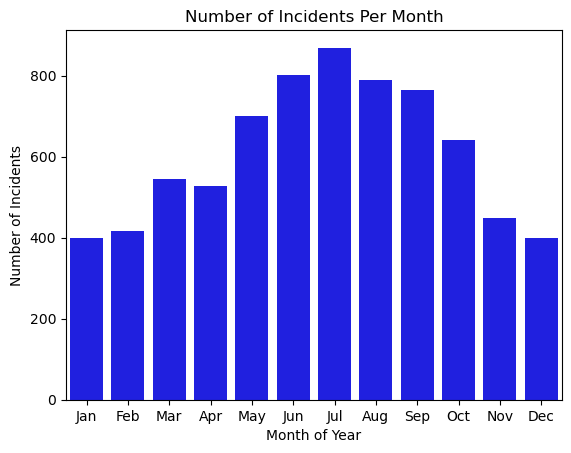

In [83]:
# Plotting Number of Incidents per Month of Year
plot = sns.countplot(x = 'Month_of_Year', color = 'b', data = df_filtered)
plot.set(xlabel = 'Month of Year', ylabel = 'Number of Incidents', title = 'Number of Incidents Per Month');